In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import gc
import h5py
import wandb
from dotenv import load_dotenv
from wandb.integration.keras import WandbCallback
from tensorflow.keras import layers, models
from torchvision import transforms
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from Changing_Architecture import mobilenet_v3_small_with_ca



In [2]:
load_dotenv()  # Load environment variables from .env file
api_key = os.getenv("WANDB_API_KEY")

wandb.login(key=api_key)  # Login with the API key
wandb_project = "MobileNetV3"
wandb_username = os.getenv("WANDB_USERNAME")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nicholas66. Use `wandb login --relogin` to force relogin


In [3]:
def load_data(hdf5_file, dataset_name_images, dataset_name_labels):
    with h5py.File(hdf5_file, 'r') as hf:
        data = np.array(hf[dataset_name_images])
        labels = np.array(hf[dataset_name_labels])
    return data, labels

# Load data
data, labels = load_data('output files/fer2013_processed.h5', 'fer2013_images', 'fer2013_labels')

# Print shapes to verify
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

# Ensure that data and labels are not empty
assert len(data) > 0, "Data is empty."
assert len(labels) > 0, "Labels are empty."

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    data, 
    labels, 
    test_size=0.2, 
    stratify=labels
)

# Print shapes of the split data
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

Data shape: (28709, 224, 224, 3)
Labels shape: (28709,)
Training data shape: (22967, 224, 224, 3)
Training labels shape: (22967,)
Validation data shape: (5742, 224, 224, 3)
Validation labels shape: (5742,)


In [4]:
# Define the data augmentation transformations
train_datagen = ImageDataGenerator(
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,           # Randomly apply shearing transformation
    zoom_range=0.2,            # Randomly zoom images by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Strategy for filling in newly created pixels
)

# Create data generator for training data
train_generator = train_datagen.flow(
    X_train,   # Training images
    y_train,   # Training labels
    batch_size=64  # Batch size for training
)

validation_datagen = ImageDataGenerator()

# Create data generator for validation data
validation_generator = validation_datagen.flow(
    X_val,  # Validation images
    y_val,  # Validation labels
    batch_size=64   # Batch size for validation
)

In [5]:
# import tensorflow as tf
# from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Add
# from tensorflow.keras.applications import MobileNetV3Small
# from tensorflow.keras.models import Model

# class ChannelAttention(Layer):
#     def __init__(self, reduction_ratio=16, **kwargs):
#         super(ChannelAttention, self).__init__(**kwargs)
#         self.reduction_ratio = reduction_ratio

#     def build(self, input_shape):
#         channels = input_shape[-1]
#         reduced_channels = max(1, channels // self.reduction_ratio)

#         self.global_avg_pool = GlobalAveragePooling2D()
#         self.reshape = Reshape((1, 1, channels))
#         self.dense1 = Dense(reduced_channels, activation='relu', use_bias=False, 
#                             kernel_initializer='he_normal')
#         self.dense2 = Dense(channels, activation='sigmoid', use_bias=False,
#                             kernel_initializer='he_normal')
#         super(ChannelAttention, self).build(input_shape)

#     def call(self, inputs):
#         x = self.global_avg_pool(inputs)
#         x = self.reshape(x)
#         x = self.dense1(x)
#         attention = self.dense2(x)
#         return inputs * attention

#     def get_config(self):
#         config = super(ChannelAttention, self).get_config()
#         config.update({'reduction_ratio': self.reduction_ratio})
#         return config


# class SpatialAttention(Layer):
#     def __init__(self, kernel_size=7, **kwargs):
#         super(SpatialAttention, self).__init__(**kwargs)
#         self.kernel_size = kernel_size

#     def build(self, input_shape):
#         self.conv = Conv2D(1, self.kernel_size, padding='same', activation='sigmoid',
#                            kernel_initializer='he_normal')
#         super(SpatialAttention, self).build(input_shape)

#     def call(self, inputs):
#         avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
#         max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
#         concat = tf.concat([avg_pool, max_pool], axis=-1)
#         attention = self.conv(concat)
#         return inputs * attention

#     def get_config(self):
#         config = super(SpatialAttention, self).get_config()
#         config.update({'kernel_size': self.kernel_size})
#         return config


# class CBAM(Layer):
#     def __init__(self, reduction_ratio=16, kernel_size=7, **kwargs):
#         super(CBAM, self).__init__(**kwargs)
#         self.reduction_ratio = reduction_ratio
#         self.kernel_size = kernel_size
#         self.channel_attention = ChannelAttention(reduction_ratio=reduction_ratio)
#         self.spatial_attention = SpatialAttention(kernel_size=kernel_size)

#     def build(self, input_shape):
#         self.channel_attention.build(input_shape)
#         self.spatial_attention.build(input_shape)
#         super(CBAM, self).build(input_shape)

#     def call(self, inputs):
#         x = self.channel_attention(inputs)
#         x = self.spatial_attention(x)
#         return x

#     def get_config(self):
#         config = super(CBAM, self).get_config()
#         config.update({
#            'reduction_ratio': self.reduction_ratio,
#             'kernel_size': self.kernel_size
#         })
#         return config


# def create_model_with_cbam(num_classes=7, input_shape=(224, 224, 3)):
#     """
#     Creates a MobileNetV3Small model with CBAM attention modules replacing SE blocks.
#     """
#     # Create base model
#     base_model = MobileNetV3Small(
#         weights=None,  # Start with random weights for testing
#         include_top=False,
#         input_shape=input_shape
#     )

#     # Create new model by replacing SE blocks
#     inputs = base_model.input
#     x = inputs

#     # Process each layer
#     for layer in base_model.layers[1:]:  # Skip input layer
#         if'squeeze_excite' in layer.name:
#             # Replace SE with CBAM
#             cbam_layer = CBAM(reduction_ratio=4, name=f'cbam_{layer.name}')
#             cbam_layer.build(layer.input_shape)
#             x = cbam_layer(x)
#         else:
#             x = layer(x)

#     # Add classification head
#     x = GlobalAveragePooling2D(name='global_pool')(x)
#     x = Dense(128, activation='relu', name='dense_1')(x)
#     x = BatchNormalization(name='bn_1')(x)
#     x = Dropout(0.5, name='dropout_1')(x)
#     x = Dense(64, activation='relu', name='dense_2')(x)
#     x = BatchNormalization(name='bn_2')(x)
#     x = Dropout(0.5, name='dropout_2')(x)
#     outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

#     # Create final model
#     model = Model(inputs=inputs, outputs=outputs)
#     return model


# # Example usage:
# if __name__ == "__main__":
#     # Create model
#     model = create_model_with_cbam()

#     # Compile model
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     # Print summary
#     model.summary()

In [6]:
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense, Multiply, Conv2D, Add, Activation, BatchNormalization
from tensorflow.keras.applications import MobileNetV3Small


# Channel Attention Module
class ChannelAttention(Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.global_avg_pool = GlobalAveragePooling2D()
        self.reshape = Reshape((1, 1, input_shape[-1]))
        self.dense1 = Dense(input_shape[-1] // self.reduction_ratio, activation='relu', use_bias=False)
        self.dense2 = Dense(input_shape[-1], activation='sigmoid', use_bias=False)

    def call(self, inputs):
        x = self.global_avg_pool(inputs)
        x = self.reshape(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return Multiply()([inputs, x])


# Spatial Attention Module
class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = Conv2D(1, kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        return Multiply()([inputs, self.conv(concat)])


# CBAM Module
class CBAM(Layer):
    def __init__(self, reduction_ratio=16, kernel_size=7, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.channel_attention = ChannelAttention(reduction_ratio=reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size=kernel_size)

    def call(self, inputs):
        x = self.channel_attention(inputs)
        x = self.spatial_attention(x)
        return x





def create_model_with_cbam():
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    inputs = base_model.input
    x = base_model.output  # Extract original output
    
    # Add CBAM to specific layers (e.g., after the last convolutional block)
    x = CBAM(reduction_ratio=16)(x)
    

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(7, activation='softmax')(x)  # Assuming 7 classes
    
    # Reassemble the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Create model
model = create_model_with_cbam()
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,063,258 (4.06 MB)

 Trainable params: 1,051,146 (4.01 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [ ]:
wandb.init(project=wandb_project, entity=wandb_username, name="MobileNetV3-CBAM")

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8),
        WandbCallback(save_graph=False, save_model=False)   # Use the callback after initializing Wandb
    ]
)

wandb.finish()

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/100


n:\Thesis 2\Code\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 2:00:29 20s/step - accuracy: 0.1094 - loss: 2.152 ━━━━━━━━━━━━━━━━━━━━ 7:20 1s/step - accuracy: 0.1172 - loss: 2.1408    ━━━━━━━━━━━━━━━━━━━━ 8:05 1s/step - accuracy: 0.1267 - loss: 2.120 ━━━━━━━━━━━━━━━━━━━━ 8:39 1s/step - accuracy: 0.1351 - loss: 2.102 ━━━━━━━━━━━━━━━━━━━━ 8:46 1s/step - accuracy: 0.1393 - loss: 2.093 ━━━━━━━━━━━━━━━━━━━━ 8:28 1s/step - accuracy: 0.1413 - loss: 2.089 ━━━━━━━━━━━━━━━━━━━━ 8:18 1s/step - accuracy: 0.1428 - loss: 2.086 ━━━━━━━━━━━━━━━━━━━━ 8:09 1s/step - accuracy: 0.1452 - loss: 2.082 ━━━━━━━━━━━━━━━━━━━━ 8:02 1s/step - accuracy: 0.1478 - loss: 2.078 ━━━━━━━━━━━━━━━━━━━━ 7:56 1s/step - accuracy: 0.1500 - loss: 2.075 ━━━━━━━━━━━━━━━━━━━━ 7:51 1s/step - accuracy: 0.1519 - loss: 2.071 ━━━━━━━━━━━━━━━━━━━━ 7:46 1s/step - accuracy: 0.1532 - loss: 2.068 ━━━━━━━━━━━━━━━━━━━━ 7:42 1s/step - accuracy: 0.1549 - loss: 2.064 ━━━━━━━━━━━━━━━━━━━━ 7:39 1s/step - accuracy: 0.1563 - loss: 2.061 ━━━━━━━━━━━━━━━━━━━━ 7:37 1s/step - accuracy: 

In [ ]:
model.save('Trained Model/MobileNetV3_CBAM.keras')

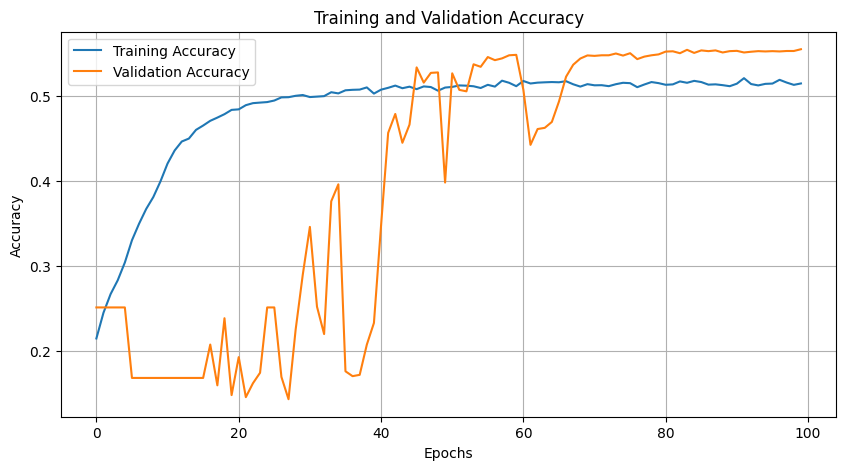

In [ ]:
import matplotlib.pyplot as plt 
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))  # Create a new figure for the plot
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Show legend
plt.grid()  # Show grid
plt.show()  # Display the plot